In [1]:
%matplotlib inline


# H.E.S.S. with Gammapy
Explore H.E.S.S. event lists and IRFs.

[H.E.S.S.](https://www.mpi-hd.mpg.de/hfm/HESS/)_ is an array of
gamma-ray telescopes located in Namibia. Gammapy is regularly used and
fully supports H.E.S.S. high level data analysis, after export to the
current [open data level 3
format](https://gamma-astro-data-formats.readthedocs.io/)_.

The H.E.S.S. data is private, and H.E.S.S. analysis is mostly documented
and discussed at https://hess-confluence.desy.de/ and in
H.E.S.S.-internal communication channels. However, in 2018, a small
sub-set of archival H.E.S.S. data was publicly released, called the
[H.E.S.S. DL3
DR1](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/)_, the data
level 3, data release number 1. This dataset is 50 MB in size and is
used in many Gammapy analysis tutorials, and can be downloaded via
[gammapy
download](https://docs.gammapy.org/dev/getting-started/index.html#quickstart-setup)_.

This notebook is a quick introduction to this specific DR1 release. It
briefly describes H.E.S.S. data and instrument responses and show a
simple exploration of the data with the creation of theta-squared plot.

H.E.S.S. members can find details on the DL3 FITS production on this
[Confluence
page](https://hess-confluence.desy.de/confluence/display/HESS/HESS+FITS+data)_
and access more detailed tutorials in this
[repository](https://bitbucket.org/hess_software/hess-open-source-tools/src/master/)_

## DL3 DR1

This is how to access data and IRFs from the H.E.S.S. data level 3, data
release 1.


In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore
from gammapy.makers import MapDatasetMaker
from gammapy.makers.utils import make_theta_squared_table
from gammapy.maps import Map, MapAxis, WcsGeom

## Check setup



In [3]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_theta_squared_table

check_tutorials_setup()

198MB [00:27, 7.45MB/s]                                                         



*** You might want to declare GAMMAPY_DATA env variable
export GAMMAPY_DATA=gammapy-data/1.0.1


System:

	python_executable      : /Users/Leo/opt/anaconda3/bin/python 
	python_version         : 3.9.12     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 1.0.1      
	path                   : /Users/Leo/opt/anaconda3/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.21.5     
	scipy                  : 1.7.3      
	astropy                : 5.0.4      
	regions                : 0.7        
	click                  : 8.0.4      
	yaml                   : 6.0        
	IPython                : 8.2.0      
	jupyterlab             : 3.3.2      
	matplotlib             : 3.5.1      
	pandas                 : 1.4.2      
	healpy                 : not installed 
	iminuit                : 2.21.3     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee    

In [4]:
import os
os.environ['GAMMAPY_DATA'] = './gammapy-data/1.0.1'

! echo $GAMMAPY_DATA

./gammapy-data/1.0.1


A useful way to organize the relevant files are the index tables. The
observation index table contains information on each particular run,
such as the pointing, or the run ID. The HDU index table has a row per
relevant file (i.e., events, effective area, psf…) and contains the path
to said file. Together they can be loaded into a Datastore by indicating
the directory in which they can be found, in this case
“$GAMMAPY_DATA/hess-dl3-dr1”:




Create and get info on the data store



In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")

data_store.info()

Data store:
HDU index table:
BASE_DIR: gammapy-data/1.0.1/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



Preview an excerpt from the observtaion table



In [6]:
display(data_store.obs_table[:2][["OBS_ID", "DATE-OBS", "RA_PNT", "DEC_PNT", "OBJECT"]])

OBS_ID,DATE-OBS,RA_PNT,DEC_PNT,OBJECT
,,deg,deg,
int64,bytes10,float32,float32,bytes18
20136,2004-03-26,228.6125,-58.771667,MSH15-52
20137,2004-03-26,228.6125,-59.771667,MSH15-52


Get a single obervation



In [7]:
obs = data_store.obs(23523)

Select and peek events



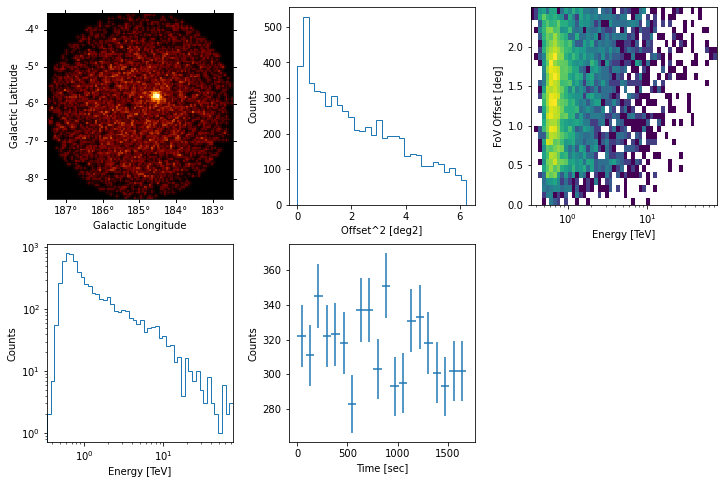

In [8]:
obs.events.select_offset([0, 2.5] * u.deg).peek()

Peek the effective area



/Users/Leo/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


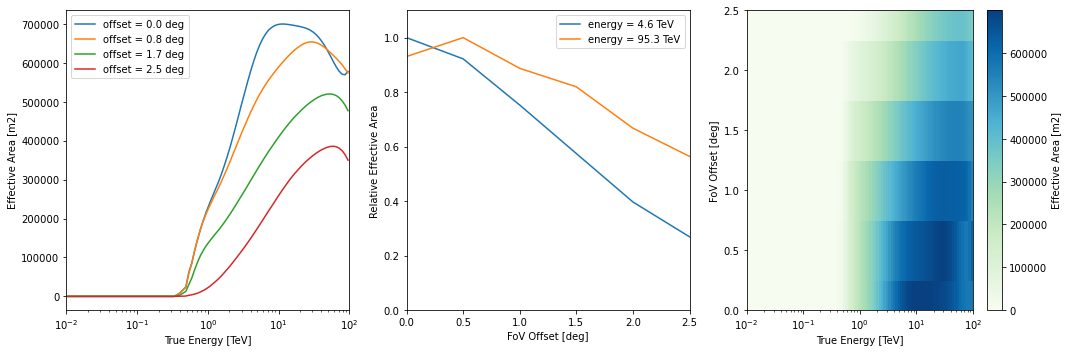

In [9]:
obs.aeff.peek()

Peek the energy dispersion



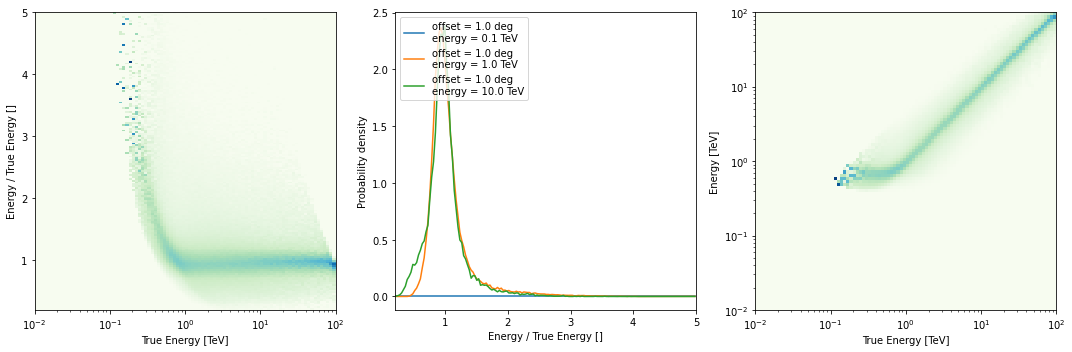

In [10]:
obs.edisp.peek()

Peek the psf



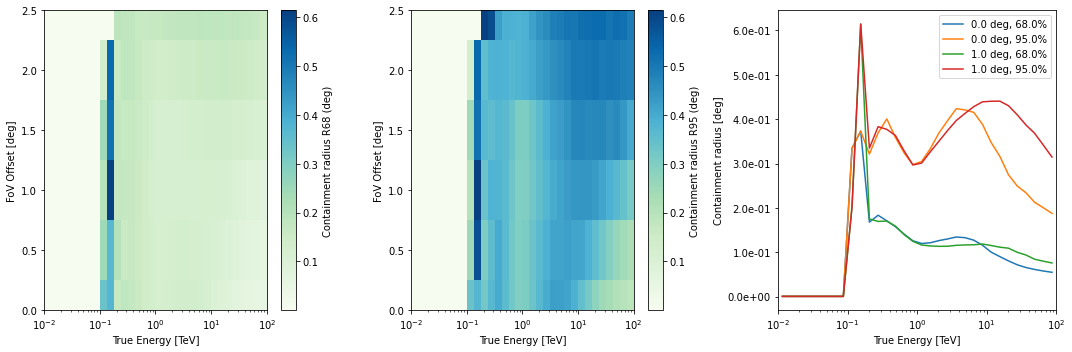

In [11]:
obs.psf.peek()

Peek the background rate



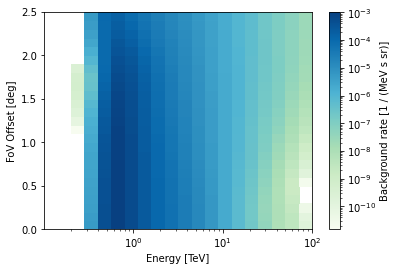

In [12]:
plt.figure()
obs.bkg.to_2d().plot()

## Theta squared event distribution

As a quick look plot it can be helpful to plot the quadratic offset
(theta squared) distribution of the events.




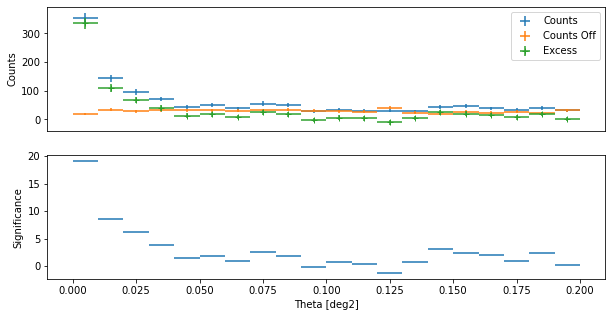

In [13]:
position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
theta2_axis = MapAxis.from_bounds(0, 0.2, nbin=20, interp="lin", unit="deg2")

observations = data_store.get_observations([23523, 23526])
theta2_table = make_theta_squared_table(
    observations=observations,
    position=position,
    theta_squared_axis=theta2_axis,
)

plt.figure(figsize=(10, 5))
plot_theta_squared_table(theta2_table)

## On-axis equivalent livetime

Since the acceptance of the H.E.S.S. camera varies within the field of
view, what is often interesting is not the simply the total number of
hours a source was observed, but the on-axis equivalent number of hours.
We calculated the same for the MSH 1552 runs here.




No. of observations:  17


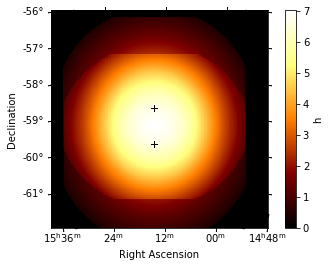

In [14]:
# Get the observations
obs_id = data_store.obs_table["OBS_ID"][data_store.obs_table["OBJECT"] == "MSH 15-5-02"]
observations = data_store.get_observations(obs_id)
print("No. of observations: ", len(observations))

# Define an energy range
energy_min = 100 * u.GeV
energy_max = 10.0 * u.TeV

# define a offset cut
offset_max = 2.5 * u.deg

# define the geom
source_pos = SkyCoord(228.32, -59.08, unit="deg")
energy_axis_true = MapAxis.from_energy_bounds(
    energy_min, energy_max, nbin=1, name="energy_true"
)
geom = WcsGeom.create(
    skydir=source_pos,
    binsz=0.02,
    width=(6, 6),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis_true],
)

# compute
livetime = Map.from_geom(geom, unit=u.hr)
for obs in observations:
    geom_obs = geom.cutout(position=obs.pointing_radec, width=2.0 * offset_max)
    exposure = MapDatasetMaker.make_exposure(geom=geom_obs, observation=obs)
    on_axis = obs.aeff.evaluate(
        offset=0.0 * u.deg, energy_true=geom.axes["energy_true"].center
    )
    on_axis = on_axis.reshape((on_axis.shape[0], 1, 1))
    lv_obs = exposure / on_axis
    livetime.stack(lv_obs)

# Plot
plt.figure()
ax = livetime.plot(add_cbar=True)

# Add the pointing position on top
for obs in observations:
    ax.plot(
        obs.pointing_radec.to_pixel(wcs=ax.wcs)[0],
        obs.pointing_radec.to_pixel(wcs=ax.wcs)[1],
        "+",
        color="black",
    )

plt.show()

## Exercises

-  Find the `OBS_ID` for the runs of the Crab nebula
-  Compute the expected number of background events in the whole RoI for
   `OBS_ID=23523` in the 1 TeV to 3 TeV energy band, from the
   background IRF.




## Next steps

Now you know how to access and work with H.E.S.S. data. All other
tutorials and documentation apply to H.E.S.S. and CTA or any other IACT
that provides DL3 data and IRFs in the standard format.


